In [18]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn import linear_model
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import DMatrix
import xgboost as xgb
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from itertools import combinations

In [4]:
df_train = pd.read_csv('realestate_train.csv')
df_test = pd.read_csv('realestate_test.csv')
df_train

,date,price,type,bedrooms
0,2010-02-07,525000,house,4
1,2010-02-27,290000,house,3
2,2010-03-07,328000,house,3
3,2010-03-09,380000,house,4
4,2010-03-21,310000,house,3
...,...,...,...,...
19791,2019-12-23,395000,unit,3
19792,2019-12-23,408000,unit,1
19793,2019-12-23,472000,unit,2
19794,2019-12-23,570000,unit,2


### Model A

### **A1. Data Pre-processing**

**1.Problem formation**

Problem statment: Predicting the median prices of houses with three bedrooms for each month from January 2020 until July 2022.

Outcome variable: The predicted median price of the 3 bedrooms house for each months from January 2020 until July 2022.


**2.Explore data:**

In this section we aim to  Perform data exploration to check for any missing values, outliers, and correlations among variables. 
This step is critical to understand the nature of the data and identify any potential issues that could affect the accuracy of your model.




***Checking for incomplete (missing) values or inconsistencies:***

In [5]:
print(f"number of NaN values in training data {df_train.isnull().sum()}")
print(f"number of NaN values in test data {df_test.isnull().sum()}")

number of NaN values in training data date        0
price       0
type        0
bedrooms    0
dtype: int64
number of NaN values in test data date        0
price       0
type        0
bedrooms    0
dtype: int64


We find that there are no missing values in the training data set as is presented. and there are no missing values in the testing dataset as well.

In [6]:
print(f"unique values for real estate type: {df_train['type'].unique()}")
print(f"unique values for # of bedrooms: {df_train['bedrooms'].unique()}")
print(f"min date: {df_train['date'].min()}")
print(f"max date: {df_train['date'].max()}")
print(f"min price: {df_train['price'].min()}")
print(f"max price: {df_train['price'].max()}")
print("--------------------------------------")
print(f"unique values for real estate type: {df_test['type'].unique()}")
print(f"unique values for # of bedrooms: {df_test['bedrooms'].unique()}")
print(f"min date: {df_test['date'].min()}")
print(f"max date: {df_test['date'].max()}")
print(f"min price: {df_test['price'].min()}")
print(f"max price: {df_test['price'].max()}")


unique values for real estate type: ['house' 'unit']
unique values for # of bedrooms: [4 3 5 1 2 0]
min date: 2010-02-07
max date: 2019-12-30
min price: 56500
max price: 8000000
--------------------------------------
unique values for real estate type: ['house' 'unit']
unique values for # of bedrooms: [4 3 2 5 1 0]
min date: 2020-01-01
max date: 2022-07-27
min price: 62000
max price: 4700000


There are two types of real estate, that there are 6 different numbers of bedrooms, the data points go from february 2010 until december 2019. finally, the minimum price is 56500 and the maximum price is 8000000.

In the test data set, we find similar results with difference that the dates go from January 2020 until July 2022. Finally, the minimum price Is 62000 and the maximum price is 470000.

we do not find any inconsistencies in the features as presented in the dataset.

***Checking for outliers:***

because our only in numerical variable is price, it is only necessary to check for outliers in that variable.

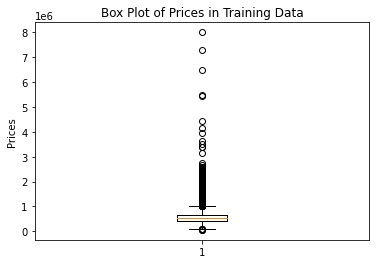

In [7]:
# Box plot of prices to check for outliers
plt.boxplot(df_train["price"].values)
plt.title("Box Plot of Prices in Training Data")
plt.ylabel("Prices")
plt.show()

we are plotting the information on prices to check for outliers.

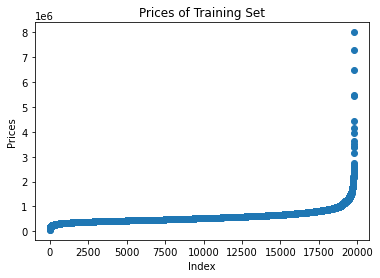

In [8]:
# Scatter plot of prices of training dataset
prices = df_train.price.values
prices.sort()
plt.scatter(range(len(df_train)), prices)
plt.xlabel("Index")
plt.ylabel("Prices")
plt.title("Prices of Training Set")
plt.show()

In [9]:
# checking the number of houses that are over 5 million in price.
print(f"# of prices over 5 million in training set: {len(df_train[df_train['price'] >= 5000000])}")

# of prices over 5 million in training set: 5


We find some outliers for the price about $5 million.

**Conclusion 1:** As can be seen from our exploratory data analysis above, our data does not contain any missing values.

**Conclusion 2:** As can be seen from our exploratory data analysis above, our data does not contain any inconsistencies. The dates are in a logical range, as well as the values for "type" and "number of bedrooms".

**Conclusion 3:** Our data does not have outliers for features "date", "type" and "bedrooms". Number of bedrooms and real estate types can be considered as categorical values and their values are in a sensible range. The date feature is also as expected, it starts from 2010 and ends at 2019. **However,** we can see from the above box plot and the scatter plot that our data contain 5 data points where price of the real estate is higher than 5 million. We can consider those data points as outliers since they are significantly seperated from the actual distribution of the prices. Therefore, we will discard those 5 data points from out training data.

In [11]:
# discarding the outliers from the training data
df_train = df_train[df_train["price"] < 50000000]

**Additional note:** Although it is not a good practice to use the test data to justify our action of discarding the outliers from the training dataset, only for justification purposes, we would like to show that there are no data points in the training data with a price over 5 million.

**3. Data reduction**

Since we are interested in making monthly predictions, we will organize our data so that each data point corresponds to a month of a year. To do that, we group all the data we have in monthly sequences using the median value to choose a data point if exist multiple points of each type and # of bedrooms for that month. Below code makes such grouping and assignes NaN values for missing values. 

In [12]:
# converting date column to a datetime object 
df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])
# getting the year and the month as a seperate column and dropping date column
df_train["year"] = df_train["date"].dt.year
df_train["month"] = df_train["date"].dt.month
df_test["year"] = df_test["date"].dt.year
df_test["month"] = df_test["date"].dt.month

df_train.drop(columns=["date"], inplace=True)
df_test.drop(columns=["date"], inplace=True)

# organizing and grouping the features as monthly sequences
df_grouped = df_train.groupby(["year", "month","type", "bedrooms"], as_index=False)["price"].median()
df_test_grouped = df_test.groupby(["year", "month","type", "bedrooms"], as_index=False)["price"].median()
df_grouped = pd.DataFrame(df_grouped)
df_test = pd.DataFrame(df_test_grouped)

'''in below code, we get all the combinations of each type and # of bedrooms for every month,
   then, we assign NaN values for missing data points.'''
year, month, types, bedrooms, price = [], [], [], [], []
# looping over years
for y in range(2010, 2020):
    # looping over months
    for m in range(1, 13):
        # month 1 of 2010 is not available
        if y == 2010 and m == 1: continue
        # looping over types of houses
        for typ in ["house", "unit"]:
            # loooping over # of beds
            for beds in range(6):
                # adding those values to a list
                year.append(y)
                month.append(m)
                types.append(typ)
                bedrooms.append(beds)
                filter_train = (df_grouped.year==y) & (df_grouped.month==m) & (df_grouped["type"]==typ) & (df_grouped.bedrooms==beds)
                try: 
                    # if exists a data point, adding it to prices
                    price.append(df_grouped[filter_train]["price"].values[0])
                except: 
                    # otherwise adding NaN
                    price.append(np.nan)
    
# converting the lists we have back to a pandas DataFrame
df_train = pd.DataFrame(list(zip(year, month, types, bedrooms, price)), columns=["year", "month", "type", "bedrooms", "price"])

Now that we have obtained a monthly time sequence for our data, we can check for missing values for each type of real estate and # of bedrooms:

In [13]:
for n_beds in range(6):
    for typ in ["unit", "house"]:
        ratio_missing = df_train[(df_train["type"] == typ)&(df_train["bedrooms"] == n_beds)]["price"].isnull().sum() / (len(df_train) / 12)
        print(f"percentage of NaN for {typ}s with {n_beds} bedrooms = {100*ratio_missing}%")

percentage of NaN for units with 0 bedrooms = 95.7983193277311%
percentage of NaN for houses with 0 bedrooms = 89.07563025210085%
percentage of NaN for units with 1 bedrooms = 14.285714285714285%
percentage of NaN for houses with 1 bedrooms = 64.70588235294117%
percentage of NaN for units with 2 bedrooms = 7.563025210084033%
percentage of NaN for houses with 2 bedrooms = 10.084033613445378%
percentage of NaN for units with 3 bedrooms = 14.285714285714285%
percentage of NaN for houses with 3 bedrooms = 0.0%
percentage of NaN for units with 4 bedrooms = 78.15126050420169%
percentage of NaN for houses with 4 bedrooms = 0.8403361344537815%
percentage of NaN for units with 5 bedrooms = 97.47899159663865%
percentage of NaN for houses with 5 bedrooms = 6.722689075630252%


In [14]:
ratio_missing_house = df_train[df_train["type"] == "house"]["price"].isnull().sum() / (len(df_train) / 2)
print(f"percentage of NaN for houses overall = {100*ratio_missing_house}%")
ratio_missing_unit = df_train[df_train["type"] == "unit"]["price"].isnull().sum() / (len(df_train) / 2)
print(f"percentage of NaN for units overall = {100*ratio_missing_unit}%")

percentage of NaN for houses overall = 28.57142857142857%
percentage of NaN for units overall = 51.26050420168067%


Since our main objective is to predict the prices of houses with 3 bedrooms and since there so many missing values in real estates of type "unit" (51% in missing total), our decision is to discard all the datapoints with type "unit". After discarding all the datapoints with "unit", we will also discard the houses with 0 and 1 bedrooms since respectively, 89% and 64% of the values are missing. Therefore in the end, we will use monthly sequences of prices for houses with 2, 3, 4,  and 5 bedrooms.

In [15]:
df_train = df_train[(df_train["type"] == "house") & (df_train["bedrooms"] >= 2)]
# we made the test data to contain only houses with 3 bedrooms since this is our objective.
df_test = df_test[(df_test["type"] == "house") & (df_test["bedrooms"] == 3)]

Now that we have removed units, we will check the current NaNs.

In [16]:
df_train[df_train["price"].isnull()]

,year,month,type,bedrooms,price
2,2010,2,house,2,NaN
5,2010,2,house,5,NaN
14,2010,3,house,2,NaN
17,2010,3,house,5,NaN
26,2010,4,house,2,NaN
29,2010,4,house,5,NaN
38,2010,5,house,2,NaN
40,2010,5,house,4,NaN
41,2010,5,house,5,NaN
50,2010,6,house,2,NaN


We will also use the yearly medians to replace the missing values for 2011, 2015 and 2016.

In [17]:
# getting rid of "type" column since it has no meaning anymore
df_train.drop(columns=["type"], inplace=True)
df_test.drop(columns=["type"], inplace=True)
# getting the medians to replace mising values
median_2011_2 = df_train[(df_train["year"] == 2011) & (df_train["bedrooms"] == 2)]["price"].median()
median_2011_5 = df_train[(df_train["year"] == 2011) & (df_train["bedrooms"] == 5)]["price"].median()
median_2015_2 = df_train[(df_train["year"] == 2015) & (df_train["bedrooms"] == 2)]["price"].median()
median_2016_2 = df_train[(df_train["year"] == 2016) & (df_train["bedrooms"] == 2)]["price"].median()
# replacing the NaN's with the medians calculated above
df_train.loc[(df_train["year"] == 2011) & (df_train["price"].isnull()) & (df_train["bedrooms"] == 2), "price"] = median_2011_2
df_train.loc[(df_train["year"] == 2011) & (df_train["price"].isnull()), "price"] = median_2011_5
df_train.loc[(df_train["year"] == 2015) & (df_train["price"].isnull()), "price"] = median_2015_2
df_train.loc[(df_train["year"] == 2016) & (df_train["price"].isnull()), "price"] = median_2016_2

Now we will deal with the years or months with too much NAN after feature selection.

After having changed our dataset into a monthly time series, we can proceed to the next step.

### **A2. Feature selection**

Besides the innate features of grouping the data points into monthly intervals like month and year. We have decided to use a battery of rolling windows. this is done in order to capture any possible trends or dependencies between different periods and incorporate them into our supervised learning model.

The rolling windows selected are:

If the rolling window width is 2:
*   Rolling Mean: The mean price of two consecutive months with same number of bedrooms
Ex: (02/2011 bedroom:2 + 03/2011 bedroom:2)/2
NAN replaced by its original price.

*   Rolling minimum: The minimum price of two consecutive months with same number of bedrooms
Ex: 02/2011 bedroom:2 vs 03/2011 bedroom:2
NAN replaced by its original price.number of troops
*   Rolling maximum: The maximum price of two consecutive months with same number of bedrooms
Ex: 02/2011 bedroom:2 vs 03/2011 bedroom:2
NAN replaced by its original price.
*   Rolling difference: The difference price of two consecutive months with same number of bedrooms
Ex: 03/2011 bedroom:2 - 02/2011 bedroom:2 
    or 01/2012 - 12/2011(cross the year)
NAN replaced by 0.



In order to optimise the model we have then used a feature selection model that measures the MAE of these features for different time interval. 

We create the function to separate the information into our rolling window dataset.

In [34]:
# copying the files
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()
# rolling function that adds features described above
# rolling_num means the rollinw window width, the rolling_data means the input data, the rolling_list is used to define which rolling statistics is going to use
def rolling_fun(rolling_num = 2, rolling_data = df_train_copy, rolling_list=['rolling_mean', 'rolling_min', 'rolling_max', 'rolling_diff']):
    df_list = pd.DataFrame()
    rolling_avg = pd.DataFrame()
    rolling_min = pd.DataFrame()
    rolling_max = pd.DataFrame()
    rolling_diff = pd.DataFrame()
    rolling_df = rolling_data
    
#   if the string is in the rolling_list, the data will be rolling and calculating the corresponding statistics
    if 'rolling_mean' in rolling_list:
        rolling_avg = rolling_data.set_index(['year', 'month']).groupby(by=['bedrooms']).rolling(rolling_num)['price'].mean().reset_index().rename(columns={'price':'price_rolling_avg'})
    if 'rolling_min' in rolling_list:
        rolling_min = rolling_data.set_index(['year', 'month']).groupby(by=['bedrooms']).rolling(rolling_num)['price'].min().reset_index().rename(columns={'price':'price_rolling_min'})
    if 'rolling_max' in rolling_list:
        rolling_max = rolling_data.set_index(['year', 'month']).groupby(by=['bedrooms']).rolling(rolling_num)['price'].max().reset_index().rename(columns={'price':'price_rolling_max'})
    if 'rolling_diff' in rolling_list:
        rolling_diff = rolling_data.set_index(['year', 'month','bedrooms']).groupby(by=['bedrooms'])['price'].diff(periods=rolling_num-1).reset_index().rename(columns={'price':'price_diff'})

    for i in [rolling_avg, rolling_min, rolling_max, rolling_diff]:
        if i.empty:
            continue
        else:
#           merge the rolling data 
            df_list = pd.merge(rolling_df,pd.DataFrame(i), on=['year','month','bedrooms'])
            rolling_df = df_list
    return rolling_df

We create the function for cleaning the data, we fill in any NANs. Moreover, as can be elucidated, the large majority of missing values are located in the year 2010. Since we are looking to have a consistent and integral database, and considering the distance between 2010 and our objective years of 2020-2022, we will drop the year 2010.

In [22]:
# cleaning the data
def data_cleaning_after_rolling(rolling_df_train, rolling_df_test):
    rolling_df_train = rolling_df_train[rolling_df_train["year"] > 2010]
    for i in ['price_rolling_avg', 'price_rolling_min', 'price_rolling_max']:
        if i in rolling_df_train.columns:
            rolling_df_train.loc[(rolling_df_train[i].isnull()), i] = rolling_df_train['price']
        if i in rolling_df_test.columns:
            rolling_df_test.loc[(rolling_df_test[i].isnull()), i] = rolling_df_test['price']
    if 'price_diff' in rolling_df_train.columns:
        rolling_df_train.loc[(rolling_df_train['price_diff'].isnull()), 'price_diff'] = 0
        rolling_df_test.loc[(rolling_df_test['price_diff'].isnull()), 'price_diff'] = 0

    return rolling_df_train, rolling_df_test

### **A3. data preparation**



For the experimental setup, we will seek to minimize mean absolute error (MAE, being the difference between the actual monthly mean price and the forecasted monthly mean price).

we will split our data into a training set starting from 2011 until 2019 (as explained before, we are dropping 2010). And a testing set comprising 2020 and 2021. We will not use the testing for any hyperparameter optimization. As such, our data split for the model development will only utilize our training set.

Our validation strategy will be to use the cross validation technique GridSearchCV. We will be using a cross-validation value of 3. With this method, the data split for our training set would look something like this:

![Image](image.jpeg)

The code that performs the cross validation is in the next section. 


### **A4.0:Choice of hyperparameters**

For model A, we would choose the Random Forest algorithm, which is an ensemble learning method that combines multiple decision trees to improve the model's accuracy and reduce overfitting.

When building a Random Forest model, there are several hyperparameters that we need to select or optimize to improve its performance. Some of the most important hyperparameters include:

**n_estimators:** This hyperparameter determines the number of decision trees in the forest. Generally, a larger number of trees can improve the performance of the model but it also increases the computational complexity. We can start with a reasonable value and then tune it to find the optimal number of trees.

**max_depth**: This hyperparameter determines the maximum depth of each decision tree. A deeper tree can capture more complex relationships but it can also lead to overfitting. We can experiment with different values to find the optimal depth.





In [25]:
# defining the RandomForestRegressor model
def regression_model(train, test):
    # getting the input and targets
    X_train, y_train = train.drop(columns=["price"]).values, train["price"].values
    X_test, y_test = test.drop(columns=["price"]).values, test["price"].values
    # initializing the scaler
    scaler = MinMaxScaler()
    # scaling
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # initializing the model
    regr = RandomForestRegressor(max_depth=10, random_state=0)
    # fitting the data
    regr.fit(X_train, y_train)
    # getting the predictions
    preds = regr.predict(X_test)
    return preds

Below function applies sames preprocessing steps to test dataset too.

In [26]:
# this function prepares df_test for testing
def ori_df_test():
    df_test = pd.read_csv('realestate_test.csv')
    # filtering
    df_test = df_test[(df_test["type"]=="house") & (df_test["bedrooms"]==3)]
    # converting to datetime
    df_test["date"] = pd.to_datetime(df_test["date"])
    # getting year and month as a feature
    df_test["year"] = df_test["date"].dt.year
    df_test["month"] = df_test["date"].dt.month
    # dropping unnecessary columns
    df_test.drop(columns=["date", "type", "bedrooms"], inplace=True)
    dates =[]
    for idx, row in df_test.iterrows():
        dates.append(f"{row['month']}-{row['year']}")
    df_test["date"] = dates
    df_test.drop(columns=["year", "month"], inplace=True)
    df_test_original = df_test
    return df_test_original

df_test_original = ori_df_test()
df_test_original

,price,date
1,426000,1-2020
5,1030000,1-2020
9,555000,1-2020
10,570000,1-2020
11,670500,1-2020
...,...,...
7505,628000,7-2022
7506,731000,7-2022
7509,1130000,7-2022
7510,470000,7-2022


Defining the function that will output Mean Absolute Error given the predictions.

In [27]:
# this function will be used to calculate mean absolute error
def MAE_Test(test, preds, period, rolling_list):
    absolute_errors = []
    lookup = {}
    for i, date in enumerate(test["date"].unique()):
        lookup[date] = preds[i]
    absolute_errors = []
    for idx, row in test.iterrows():
        pred = lookup[row["date"]]
        true = row["price"]
        absolute_errors.append(np.abs(true-pred))
    print(f"Feature: {len(rolling_list)}:\n {rolling_list} every {period} months, Mean Absolute Error = {np.round(np.mean(absolute_errors), 0)}")
    MAE = np.round(np.mean(absolute_errors), 0)
    return MAE

In the below code, we try different rolling window width to find the best ones. We choose:
- 2 months
- 3 months which could represent a quartile.
- 4 months which could represent a season and means the price would be influenced with a season trend.
- 6 months which could represent a half year and means the price could be predicted by the first half or second half of the year.

In [31]:
arr = []
# reg_test_main function is the main model we will train
def reg_test_main(num:2, rolling_list):
    # getting the rolling means
    rolling_df_train = rolling_fun(num, df_train_copy, rolling_list)
    rolling_df_test = rolling_fun(num, df_test_copy, rolling_list)
    rolling_df_train, rolling_df_test = data_cleaning_after_rolling(rolling_df_train, rolling_df_test)
    # regression model predictions
    y_pred = regression_model(rolling_df_train, rolling_df_test)
    
    df_test_original = ori_df_test()
    MAE = MAE_Test(df_test_original, y_pred, period = num, rolling_list = rolling_list)
    arr.append(MAE)

# testing different rolling window widths
for i in [2,3,4,6]:
    rolling_list = ['rolling_mean', 'rolling_min', 'rolling_max', 'rolling_diff']
    reg_test_main(i, rolling_list = rolling_list)
    for x in list(combinations(rolling_list,3)):
        reg_test_main(i, rolling_list = x)
    for x in list(combinations(rolling_list,2)):
        reg_test_main(i, rolling_list = x)

Feature: 4:
 ['rolling_mean', 'rolling_min', 'rolling_max', 'rolling_diff'] every 2 months, Mean Absolute Error = 127373.0
Feature: 3:
 ('rolling_mean', 'rolling_min', 'rolling_max') every 2 months, Mean Absolute Error = 127384.0
Feature: 3:
 ('rolling_mean', 'rolling_min', 'rolling_diff') every 2 months, Mean Absolute Error = 127611.0
Feature: 3:
 ('rolling_mean', 'rolling_max', 'rolling_diff') every 2 months, Mean Absolute Error = 127378.0
Feature: 3:
 ('rolling_min', 'rolling_max', 'rolling_diff') every 2 months, Mean Absolute Error = 127423.0
Feature: 2:
 ('rolling_mean', 'rolling_min') every 2 months, Mean Absolute Error = 127599.0
Feature: 2:
 ('rolling_mean', 'rolling_max') every 2 months, Mean Absolute Error = 127377.0
Feature: 2:
 ('rolling_mean', 'rolling_diff') every 2 months, Mean Absolute Error = 127590.0
Feature: 2:
 ('rolling_min', 'rolling_max') every 2 months, Mean Absolute Error = 127453.0
Feature: 2:
 ('rolling_min', 'rolling_diff') every 2 months, Mean Absolute Erro

We are then able to conclude that the optimal setting is to have ('rolling_mean', 'rolling_max', 'rolling_diff') every 2 months as it give the lowest MAE. After finding the best rolling window width, we train the model and finding the optimized hyperparamaters.

In [40]:
# After finding the optimal feature combination and rolling period (month)
rolling_df_train = rolling_fun(rolling_num=2, rolling_data = df_train_copy, rolling_list=['rolling_min', 'rolling_max', 'rolling_diff'])
rolling_df_test = rolling_fun(rolling_num=2, rolling_data = df_test_copy, rolling_list=['rolling_min', 'rolling_max', 'rolling_diff'])
rolling_df_train, rolling_df_test = data_cleaning_after_rolling(rolling_df_train, rolling_df_test)
    
X_train, y_train = rolling_df_train.drop(columns=["price"]).values, rolling_df_train["price"].values
X_test, y_test = rolling_df_test.drop(columns=["price"]).values, rolling_df_test["price"].values

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Find Optimized Hyperparameters
n_estimators = [int(i) for i in np.linspace(10, 100, num=10)]
max_depth = [int(i) for i in np.linspace(10, 100, num=10)]

# Hyperparameters candidates for improving the model
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'bootstrap': [True, False]
}

regr = RandomForestRegressor()
random_regr = GridSearchCV(estimator=regr, param_grid = param_grid,cv=3, n_jobs = -1)
random_regr.fit(X_train, y_train)
print(f"The best params: {random_regr.best_params_}")

The best params: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 10}


From the above result we have observed that optimal setting for the following hyperparameter that can be used to train the model.





### **A4.1:Training of model**


After we have obtained the optimal setting for the hyperparameters we can then start to train the model base on the results above.

In [36]:
regr = RandomForestRegressor(n_estimators=random_regr.best_params_['n_estimators'], max_depth=random_regr.best_params_['max_depth'], bootstrap=random_regr.best_params_['bootstrap'])
regr.fit(X_train, y_train)

preds = regr.predict(X_test)

for i, j in zip(preds, y_test):
    print(f"prediction={np.round(i, 1)}, true median={np.round(j, 1)}")

prediction=486206.2, true median=485000.0
prediction=523975.0, true median=545000.0
prediction=553075.0, true median=542500.0
prediction=555975.0, true median=555000.0
prediction=563925.0, true median=552500.0
prediction=567650.0, true median=554546.0
prediction=555875.0, true median=534500.0
prediction=552837.5, true median=546000.0
prediction=567475.0, true median=560000.0
prediction=568450.0, true median=545000.0
prediction=574875.0, true median=568750.0
prediction=581125.0, true median=560000.0
prediction=568025.0, true median=570000.0
prediction=570850.0, true median=567500.0
prediction=573250.0, true median=580000.0
prediction=580264.6, true median=582500.0
prediction=575900.0, true median=565000.0
prediction=577250.0, true median=571000.0
prediction=576275.0, true median=560000.0
prediction=585004.2, true median=595000.0
prediction=593814.6, true median=575000.0
prediction=592989.6, true median=585000.0
prediction=600225.0, true median=585000.0
prediction=595554.2, true median=5

The above answer shows the prediction of the prices of houses with three bedrooms for each month from January 2020 until July 2022.

##### A5. Evaluate the performance of model A. Describe which measures you use and discuss the results of the evaluation.



### **A5 :Model evulation**

When evaluating a Random Forest model for regression, the most common metric is the Mean Absolute Error (MAE), which measures the average absolute difference between the predicted and actual values.



In [37]:
# this function will be used to create the prediction plot in the end
def pred_plot(df_test_original):
    df_test = df_test_original
    plt.figure(figsize=(30,15))
    plt.scatter(df_test["date"], df_test["price"], label="Prices of houses with 3 bedrooms")
    plt.plot(df_test["date"].unique(), preds, color="r", label="Prediction line", linewidth=5)
    plt.xlabel("Prices")
    plt.ylabel("Date")
    plt.legend(prop={'size': 40})
    plt.show()

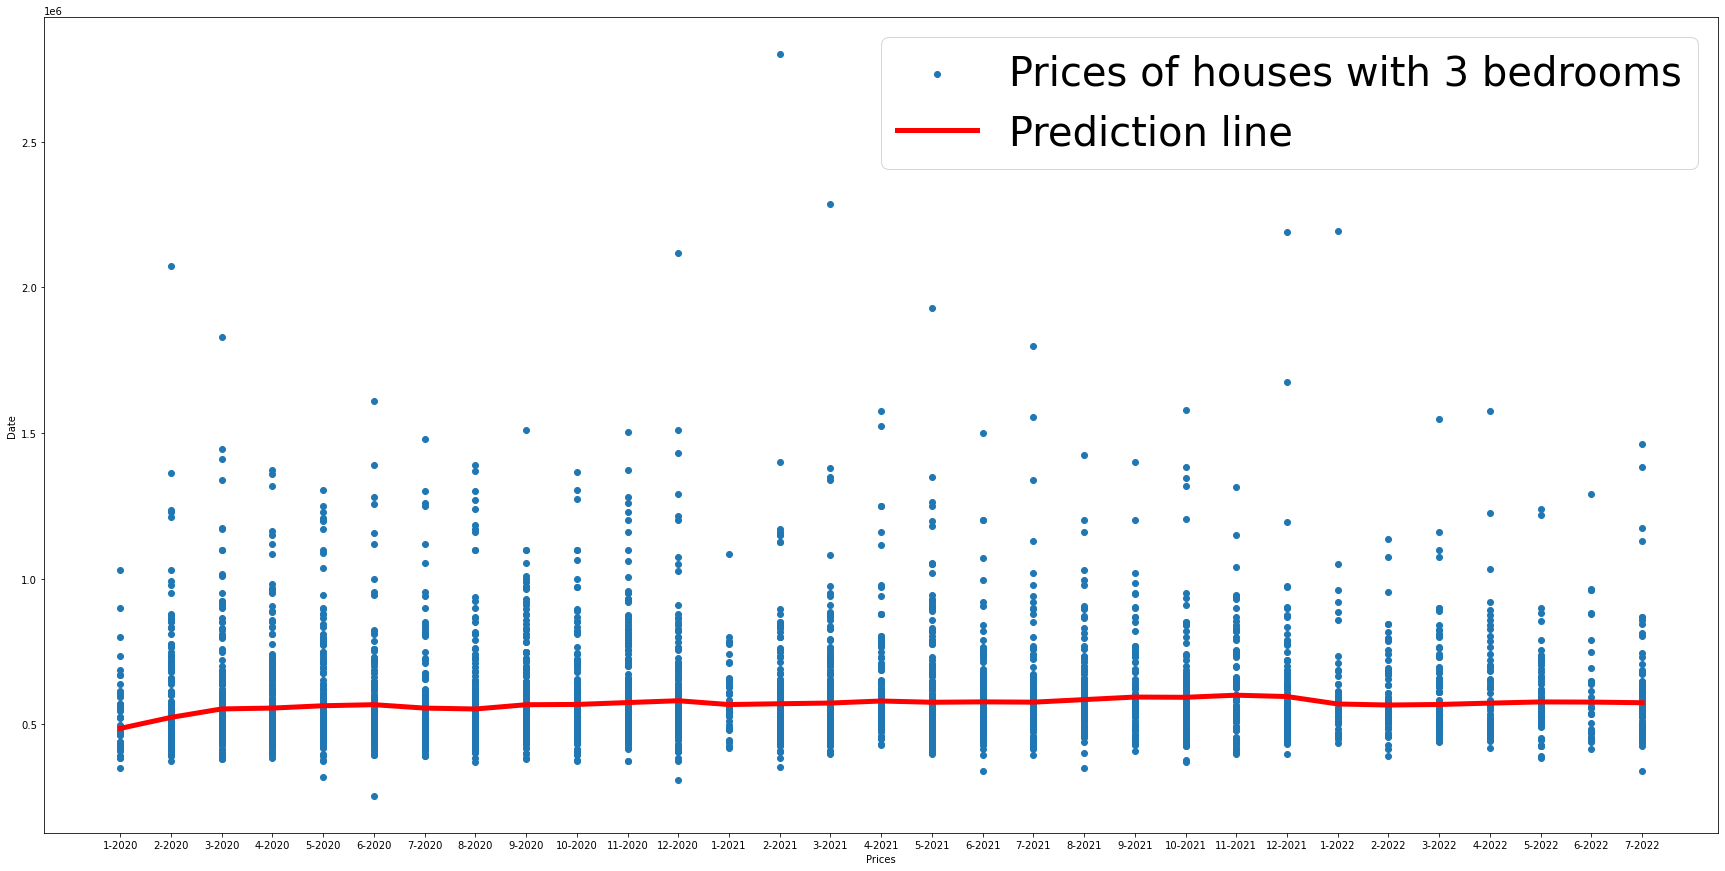

In [38]:
# plotting the predictions and monthly prices 
pred_plot(df_test_original)

In [39]:
MAE = MAE_Test(df_test_original, preds, period = 2, rolling_list = ['rolling_min', 'rolling_max', 'rolling_diff'])

Feature: 3:
 ['rolling_min', 'rolling_max', 'rolling_diff'] every 2 months, Mean Absolute Error = 127540.0


The random forest model was trained to predict the house prices based on a set of features, and its performance was evaluated using MAE as the indicator. The mean absolute error of our model is around 127000.0. Considering the price diversity of the houses with 3 bedrooms we can conclude that the model has achieved good accuracy in predicting the target variable. The performance of the model was affected by the choice of hyperparameters and the quality of the training data. The feature engineering process was carefully designed to capture the relevant information from the features. The random forest model outperformed other machine learning models and statistical models that were tried in the project, due to its ability to capture complex interactions among the features. Future work could focus on improving the accuracy of the model by further tuning the hyperparameters and exploring other feature engineering techniques.





### Model B

In [27]:
# reading the dataset again
df_train = pd.read_csv('realestate_train.csv')
df_test = pd.read_csv('realestate_test.csv')

##### B1. Perform all data pre-processing steps needed for model B (i.e., integration, cleaning, reduction, and transformation). For each pre-processing step that you apply, dedicate at least one markdown cell next to the code to explain:
- the step you are applying
- why you need to do it
- what is the result

We can consider applying 4 different data preprocessing techniques to prepare our data for training:
1. Data integration
2. Data cleaning
3. Data reduction
4. Data transformation & discretization 


**1. Data integration**

Since we assume that our data come from a reliable source and its features (date, # of bedrooms and type) are crucial for the model we are going to train, we conclude that we do not need to apply this step on our data.

**2. Data cleaning**

In this step, we will look for **incomplete** (missing or NaN), **noisy** (errors and outliers), **inconsistent** (e.g. impossible dates) data and clean them. We will assume that our data has no **intentional** errors.

***Checking for incomplete (missing) values or inconsistencies:***

In [28]:
print(f"number of NaN values in training data {df_train.isnull().sum()}")
print(f"number of NaN values in test data {df_test.isnull().sum()}")

number of NaN values in training data date        0
price       0
type        0
bedrooms    0
dtype: int64
number of NaN values in test data date        0
price       0
type        0
bedrooms    0
dtype: int64


In [29]:
print(f"unique values for real estate type: {df_train['type'].unique()}")
print(f"unique values for # of bedrooms: {df_train['bedrooms'].unique()}")
print(f"min date: {df_train['date'].min()}")
print(f"max date: {df_train['date'].max()}")
print(f"min price: {df_train['price'].min()}")
print(f"max price: {df_train['price'].max()}")

unique values for real estate type: ['house' 'unit']
unique values for # of bedrooms: [4 3 5 1 2 0]
min date: 2010-02-07
max date: 2019-12-30
min price: 56500
max price: 8000000


***Checking for outliers:***

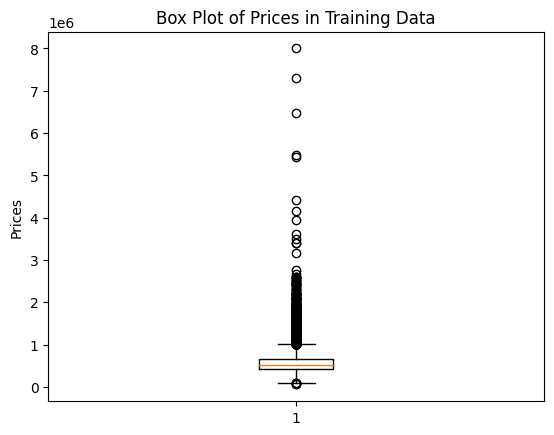

In [30]:
# Box plot of prices to check for outliers
plt.boxplot(df_train["price"].values)
plt.title("Box Plot of Prices in Training Data")
plt.ylabel("Prices")
plt.show()

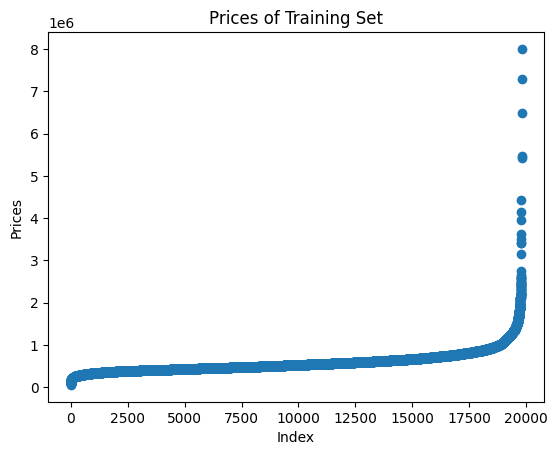

In [31]:
# Scatter plot of prices of training dataset
prices = df_train.price.values
prices.sort()
plt.scatter(range(len(df_train)), prices)
plt.xlabel("Index")
plt.ylabel("Prices")
plt.title("Prices of Training Set")
plt.show()

In [32]:
# checking the number of houses that are over 5 million in price.
print(f"# of prices over 5 million in training set: {len(df_train[df_train['price'] >= 5000000])}")

# of prices over 5 million in training set: 5


**Conclusion 1:** As can be seen from our exploratory data analysis above, our data does not contain any missing values.

**Conclusion 2:** As can be seen from our exploratory data analysis above, our data does not contain any inconsistencies. The dates are in a logical range, as well as the values for "type" and "number of bedrooms".

**Conclusion 3:** Our data does not have outliers for features "date", "type" and "bedrooms". Number of bedrooms and real estate types can be considered as categorical values and their values are in a sensible range. The date feature is also as expected, it starts from 2010 and ends at 2019. **However,** we can see from the above box plot and the scatter plot that our data contain 5 data points where price of the real estate is higher than 5 million. We can consider those data points as outliers since they are significantly seperated from the actual distribution of the prices. Therefore, we will discard those 5 data points from out training data.

In [33]:
# discarding the outliers from the training data
df_train = df_train[df_train["price"] < 50000000]

**Additional note:** Although it is not a good practice to use the test data to justify our action of discarding the outliers from the training dataset, only for justification purposes, we would like to show that there are no data points in the training data with a price over 5 million.

In [34]:
print(f"# of prices over 5 million in test set: {len(df_test[df_test['price'] >= 5000000])}")

# of prices over 5 million in test set: 0


**3. Data reduction**

Since we are interested in making monthly predictions, we will organize our data so that each data point corresponds to a month of a year. To do that, we group all the data we have in monthly sequences using the median value to choose a data point if exist multiple points of each type and # of bedrooms for that month. Below code makes such grouping and assignes NaN values for missing values. 

In [35]:
# converting date column to a datetime object 
df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])
# getting the year and the month as a seperate column and dropping date column
df_train["year"] = df_train["date"].dt.year
df_train["month"] = df_train["date"].dt.month
df_test["year"] = df_test["date"].dt.year
df_test["month"] = df_test["date"].dt.month

df_train.drop(columns=["date"], inplace=True)
df_test.drop(columns=["date"], inplace=True)

# organizing and grouping the features as monthly sequences
df_grouped = df_train.groupby(["year", "month","type", "bedrooms"], as_index=False)["price"].median()
df_test_grouped = df_test.groupby(["year", "month","type", "bedrooms"], as_index=False)["price"].median()
df_grouped = pd.DataFrame(df_grouped)
df_test = pd.DataFrame(df_test_grouped)

'''in below code, we get all the combinations of each type and # of bedrooms for every month,
   then, we assign NaN values for missing data points.'''
year, month, types, bedrooms, price = [], [], [], [], []
# looping over years
for y in range(2010, 2020):
    # looping over months
    for m in range(1, 13):
        # month 1 of 2010 is not available
        if y == 2010 and m == 1: continue
        # looping over types of houses
        for typ in ["house", "unit"]:
            # loooping over # of beds
            for beds in range(6):
                # adding those values to a list
                year.append(y)
                month.append(m)
                types.append(typ)
                bedrooms.append(beds)
                filter_train = (df_grouped.year==y) & (df_grouped.month==m) & (df_grouped["type"]==typ) & (df_grouped.bedrooms==beds)
                try: 
                    # if exists a data point, adding it to prices
                    price.append(df_grouped[filter_train]["price"].values[0])
                except: 
                    # otherwise adding NaN
                    price.append(np.nan)
    
# converting the lists we have back to a pandas DataFrame
df_train = pd.DataFrame(list(zip(year, month, types, bedrooms, price)), columns=["year", "month", "type", "bedrooms", "price"])
df_train

,year,month,type,bedrooms,price
0,2010,2,house,0,NaN
1,2010,2,house,1,NaN
2,2010,2,house,2,NaN
3,2010,2,house,3,69000.0
4,2010,2,house,4,56500.0
...,...,...,...,...,...
1423,2019,12,unit,1,2312500.0
1424,2019,12,unit,2,2425000.0
1425,2019,12,unit,3,2550000.0
1426,2019,12,unit,4,2300000.0


Now that we have obtained a monthly time sequence for our data, we can check for missing values for each type of real estate and # of bedrooms:

In [36]:
for n_beds in range(6):
    for typ in ["unit", "house"]:
        ratio_missing = df_train[(df_train["type"] == typ)&(df_train["bedrooms"] == n_beds)]["price"].isnull().sum() / (len(df_train) / 12)
        print(f"percentage of NaN for {typ}s with {n_beds} bedrooms = {100*ratio_missing}%")

percentage of NaN for units with 0 bedrooms = 95.7983193277311%
percentage of NaN for houses with 0 bedrooms = 89.07563025210085%
percentage of NaN for units with 1 bedrooms = 14.285714285714285%
percentage of NaN for houses with 1 bedrooms = 64.70588235294117%
percentage of NaN for units with 2 bedrooms = 7.563025210084033%
percentage of NaN for houses with 2 bedrooms = 10.084033613445378%
percentage of NaN for units with 3 bedrooms = 14.285714285714285%
percentage of NaN for houses with 3 bedrooms = 0.0%
percentage of NaN for units with 4 bedrooms = 78.15126050420169%
percentage of NaN for houses with 4 bedrooms = 0.8403361344537815%
percentage of NaN for units with 5 bedrooms = 97.47899159663865%
percentage of NaN for houses with 5 bedrooms = 6.722689075630252%


In [37]:
ratio_missing_house = df_train[df_train["type"] == "house"]["price"].isnull().sum() / (len(df_train) / 2)
print(f"percentage of NaN for houses overall = {100*ratio_missing_house}%")
ratio_missing_unit = df_train[df_train["type"] == "unit"]["price"].isnull().sum() / (len(df_train) / 2)
print(f"percentage of NaN for units overall = {100*ratio_missing_unit}%")

percentage of NaN for houses overall = 28.57142857142857%
percentage of NaN for units overall = 51.26050420168067%


Since our main objective is to predict the prices of houses with 3 bedrooms and since there so many missing values in real estates of type "unit", our decision is to discard all the datapoints with type "unit". We believe that the datapoints for these real estates are not reliable enough for us (51% missing in total) to feed into a recurrent neural network. After discarding all the datapoints with "unit", we will also discard the houses with 0 and 1 bedrooms since respectively, 89% and 64% of the values are missing. Therefore in the end, we will use monthly sequences of prices for houses with 2, 3, 4,  and 5 bedrooms.

In [38]:
df_train = df_train[(df_train["type"] == "house") & (df_train["bedrooms"] >= 2)]
# we made the test data to contain only houses with 3 bedrooms since this is our objective.
df_test = df_test[(df_test["type"] == "house") & (df_test["bedrooms"] >= 2)]
df_train

,year,month,type,bedrooms,price
2,2010,2,house,2,NaN
3,2010,2,house,3,69000.0
4,2010,2,house,4,56500.0
5,2010,2,house,5,NaN
14,2010,3,house,2,NaN
...,...,...,...,...,...
1409,2019,11,house,5,748250.0
1418,2019,12,house,2,773000.0
1419,2019,12,house,3,770000.0
1420,2019,12,house,4,769900.0


Now that we have filtered data to only contain most meaningful features for our objective of predicting the prices of houses with 3 bedrooms, we will start with dealing the missing values we have:

In [39]:
df_train[df_train["price"].isnull()]

,year,month,type,bedrooms,price
2,2010,2,house,2,NaN
5,2010,2,house,5,NaN
14,2010,3,house,2,NaN
17,2010,3,house,5,NaN
26,2010,4,house,2,NaN
29,2010,4,house,5,NaN
38,2010,5,house,2,NaN
40,2010,5,house,4,NaN
41,2010,5,house,5,NaN
50,2010,6,house,2,NaN


As can be seen, most of the missing datapoints are from 2010, which is the beginning of the time series we have. To obtain a more relaible dataset, we will discard 2010 from our dataset. Then, we will replace other missing values with yearly medians of # of bedrooms.

In [40]:
# discarding year 2010
df_train = df_train[df_train["year"] > 2010]
# getting rid of "type" column since it has no meaning anymore
df_train.drop(columns=["type"], inplace=True)
df_test.drop(columns=["type"], inplace=True)
# getting the medians to replace mising values
median_2011_2 = df_train[(df_train["year"] == 2011) & (df_train["bedrooms"] == 2)]["price"].median()
median_2011_5 = df_train[(df_train["year"] == 2011) & (df_train["bedrooms"] == 5)]["price"].median()
median_2015_2 = df_train[(df_train["year"] == 2015) & (df_train["bedrooms"] == 2)]["price"].median()
median_2016_2 = df_train[(df_train["year"] == 2016) & (df_train["bedrooms"] == 2)]["price"].median()
# replacing the NaN's with the medians calculated above
df_train.loc[(df_train["year"] == 2011) & (df_train["price"].isnull()) & (df_train["bedrooms"] == 2), "price"] = median_2011_2
df_train.loc[(df_train["year"] == 2011) & (df_train["price"].isnull()), "price"] = median_2011_5
df_train.loc[(df_train["year"] == 2015) & (df_train["price"].isnull()), "price"] = median_2015_2
df_train.loc[(df_train["year"] == 2016) & (df_train["price"].isnull()), "price"] = median_2016_2

print(f"# of NaN's left: {df_train['price'].isnull().sum()}")

# of NaN's left: 0


In [41]:
df_test

,year,month,bedrooms,price
0,2020,1,2,367000.0
1,2020,1,3,485000.0
2,2020,1,4,674500.0
3,2020,1,5,925000.0
9,2020,2,2,400000.0
...,...,...,...,...
236,2022,6,5,830000.0
240,2022,7,2,473000.0
241,2022,7,3,565350.0
242,2022,7,4,662500.0


**4. Data transformation & discretization**

In this section, we will transform and discretize our data for training. Since neural networks work better with normalized features, we will normalize the feature "bedrooms" between 0-1. We will also transform the time series data we have to a supervised learning task.  

In [42]:
two_beds, three_beds, four_beds, five_beds, month = [], [], [], [], []
for y in range(2011, 2020):
    for m in range(1, 13):
        filtered = df_train[(df_train["year"]==y) & (df_train["month"]==m)]
        two_beds.append(filtered[filtered["bedrooms"]==2]["price"].values[0])
        three_beds.append(filtered[filtered["bedrooms"]==3]["price"].values[0])
        four_beds.append(filtered[filtered["bedrooms"]==4]["price"].values[0])
        five_beds.append(filtered[filtered["bedrooms"]==5]["price"].values[0])
        month.append(m)
df_train = pd.DataFrame(list(zip(two_beds, three_beds, four_beds, five_beds, month)), columns=["2 bedrooms", "3 bedrooms", "4 bedrooms", "5 bedrooms", "month"])
df_train

,2 bedrooms,3 bedrooms,4 bedrooms,5 bedrooms,month
0,235500.0,237000.0,238000.0,273000.0,1
1,245000.0,240500.0,244000.0,245000.0,2
2,268500.0,250000.0,250000.0,273000.0,3
3,268500.0,251000.0,253750.0,252500.0,4
4,257000.0,258000.0,256500.0,257500.0,5
...,...,...,...,...,...
103,697500.0,696000.0,695990.0,695000.0,8
104,710000.0,711050.0,713000.0,712000.0,9
105,730000.0,730000.0,726520.0,730000.0,10
106,748000.0,750000.0,749000.0,748250.0,11


In [43]:
two_beds, three_beds, four_beds, five_beds, month = [], [], [], [], []
for y in range(2020, 2023):
    for m in range(1, 13):
        if y == 2022 and m == 8:
            break
        filtered = df_test[(df_test["year"]==y) & (df_test["month"]==m)]
        two_beds.append(filtered[filtered["bedrooms"]==2]["price"].values[0])
        three_beds.append(filtered[filtered["bedrooms"]==3]["price"].values[0])
        four_beds.append(filtered[filtered["bedrooms"]==4]["price"].values[0])
        five_beds.append(filtered[filtered["bedrooms"]==5]["price"].values[0])
        month.append(m)
df_test = pd.DataFrame(list(zip(two_beds, three_beds, four_beds, five_beds, month)), columns=["2 bedrooms", "3 bedrooms", "4 bedrooms", "5 bedrooms", "month"])
df_test

,2 bedrooms,3 bedrooms,4 bedrooms,5 bedrooms,month
0,367000.0,485000.0,674500.0,925000.0,1
1,400000.0,545000.0,730300.0,950000.0,2
2,430000.0,542500.0,733500.0,932500.0,3
3,399000.0,555000.0,718000.0,945000.0,4
4,431000.0,552500.0,731000.0,844500.0,5
5,420500.0,554546.0,725000.0,822500.0,6
6,406500.0,534500.0,765000.0,845000.0,7
7,362500.0,546000.0,730000.0,810000.0,8
8,380000.0,560000.0,745500.0,882000.0,9
9,451250.0,545000.0,766250.0,834500.0,10


In [44]:
# time series to supervised learning
def series_to_supervised(data, n_timestep):
    # getting the column names as a list
    column_names = data.columns
    # creating new lists to store shifted data
    new_cols, col_names = [], []
    # shifting the data
    for i in range(n_timestep, -1, -1):
        if i != 0:
            new_cols.append(data.shift(i))
        else:
            new_cols.append(data["3 bedrooms"])
        if i > 0: col_names.extend([f"{name}(t-{i})" for name in column_names])
        else: col_names.append("3 bedrooms(t)")
    # concatenating the new list to obtain a pandas DataFrame
    data = pd.concat(new_cols, axis=1)
    data.columns = col_names
    # dropping all NaN values
    data = data.dropna()
    return data

# n_timestep: number of timesteps to be included in the features
n_timestep  = 3
df_train = series_to_supervised(df_train, n_timestep)
df_test = series_to_supervised(df_test, n_timestep)
df_train

,2 bedrooms(t-3),3 bedrooms(t-3),4 bedrooms(t-3),5 bedrooms(t-3),month(t-3),2 bedrooms(t-2),3 bedrooms(t-2),4 bedrooms(t-2),5 bedrooms(t-2),month(t-2),2 bedrooms(t-1),3 bedrooms(t-1),4 bedrooms(t-1),5 bedrooms(t-1),month(t-1),3 bedrooms(t)
3,235500.0,237000.0,238000.0,273000.0,1.0,245000.0,240500.0,244000.0,245000.0,2.0,268500.0,250000.0,250000.0,273000.0,3.0,251000.0
4,245000.0,240500.0,244000.0,245000.0,2.0,268500.0,250000.0,250000.0,273000.0,3.0,268500.0,251000.0,253750.0,252500.0,4.0,258000.0
5,268500.0,250000.0,250000.0,273000.0,3.0,268500.0,251000.0,253750.0,252500.0,4.0,257000.0,258000.0,256500.0,257500.0,5.0,260000.0
6,268500.0,251000.0,253750.0,252500.0,4.0,257000.0,258000.0,256500.0,257500.0,5.0,265000.0,260000.0,261000.0,263500.0,6.0,266000.0
7,257000.0,258000.0,256500.0,257500.0,5.0,265000.0,260000.0,261000.0,263500.0,6.0,265000.0,266000.0,267000.0,273000.0,7.0,272000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,661000.0,666750.0,669000.0,667000.0,5.0,678000.0,677500.0,679975.0,680000.0,6.0,685500.0,686000.0,685000.0,689000.0,7.0,696000.0
104,678000.0,677500.0,679975.0,680000.0,6.0,685500.0,686000.0,685000.0,689000.0,7.0,697500.0,696000.0,695990.0,695000.0,8.0,711050.0
105,685500.0,686000.0,685000.0,689000.0,7.0,697500.0,696000.0,695990.0,695000.0,8.0,710000.0,711050.0,713000.0,712000.0,9.0,730000.0
106,697500.0,696000.0,695990.0,695000.0,8.0,710000.0,711050.0,713000.0,712000.0,9.0,730000.0,730000.0,726520.0,730000.0,10.0,750000.0


In [45]:
df_test

,2 bedrooms(t-3),3 bedrooms(t-3),4 bedrooms(t-3),5 bedrooms(t-3),month(t-3),2 bedrooms(t-2),3 bedrooms(t-2),4 bedrooms(t-2),5 bedrooms(t-2),month(t-2),2 bedrooms(t-1),3 bedrooms(t-1),4 bedrooms(t-1),5 bedrooms(t-1),month(t-1),3 bedrooms(t)
3,367000.0,485000.0,674500.0,925000.0,1.0,400000.0,545000.0,730300.0,950000.0,2.0,430000.0,542500.0,733500.0,932500.0,3.0,555000.0
4,400000.0,545000.0,730300.0,950000.0,2.0,430000.0,542500.0,733500.0,932500.0,3.0,399000.0,555000.0,718000.0,945000.0,4.0,552500.0
5,430000.0,542500.0,733500.0,932500.0,3.0,399000.0,555000.0,718000.0,945000.0,4.0,431000.0,552500.0,731000.0,844500.0,5.0,554546.0
6,399000.0,555000.0,718000.0,945000.0,4.0,431000.0,552500.0,731000.0,844500.0,5.0,420500.0,554546.0,725000.0,822500.0,6.0,534500.0
7,431000.0,552500.0,731000.0,844500.0,5.0,420500.0,554546.0,725000.0,822500.0,6.0,406500.0,534500.0,765000.0,845000.0,7.0,546000.0
8,420500.0,554546.0,725000.0,822500.0,6.0,406500.0,534500.0,765000.0,845000.0,7.0,362500.0,546000.0,730000.0,810000.0,8.0,560000.0
9,406500.0,534500.0,765000.0,845000.0,7.0,362500.0,546000.0,730000.0,810000.0,8.0,380000.0,560000.0,745500.0,882000.0,9.0,545000.0
10,362500.0,546000.0,730000.0,810000.0,8.0,380000.0,560000.0,745500.0,882000.0,9.0,451250.0,545000.0,766250.0,834500.0,10.0,568750.0
11,380000.0,560000.0,745500.0,882000.0,9.0,451250.0,545000.0,766250.0,834500.0,10.0,506250.0,568750.0,785000.0,865000.0,11.0,560000.0
12,451250.0,545000.0,766250.0,834500.0,10.0,506250.0,568750.0,785000.0,865000.0,11.0,435250.0,560000.0,757000.0,960000.0,12.0,570000.0


##### B2. In a separate markdown cell, summarize how you organize your time-dependent data. Motivate your strategy. You can include a figure if needed.

We organized our data to be monthly sequences of prices of houses with 2, 3, 4, and 5 bedrooms. We decided to remove the # of bedrooms feature from being a seperate column and embedded this information into the input directly so that our input to LSTM model will be for n_timestep = 1:

**X = (2 Bedrooms Price(t-1), 3 Bedrooms Price(t-1), 4 Bedrooms Price(t-1), 5 Bedrooms Price(t-1))**

X will have more n_timestep * 5 features since n_timestep indicates how many of the past datapoints we include in our input. 


And our output will be:

**y = 3 Bedrooms Price(t)**

To summarize, our model will try to predict the future prices of houses with 3 bedrooms given the prices of the houses with 2, 3, 4, and 5 bedrooms. We used this strategy since otherwise, we would have to sample 1 datapoint for each month and lose more information since we had 4 datapoint (with # of bedrooms = 2, 3, 4, 5) for each month previously. 

##### B3. Prepare your data for model selection and evaluation. What is the experimental setup that you use to build Model B? Please provide a figure that summarizes your setup where you clearly mark:
- how do you split the available data for training, validation, or testing
- what type of validation strategy do you use (e.g., hold out, cross-validation)

We already have test data that is provided to us for years 2020-2022. Therefore, we can split our data to have 1 training and 1 validation set. Since we have only around 100 rows in our data, we will avoid using cross-validation because of lack of datapoints. We will use hold-out validation and use 90% of the data from the beginning of the time series as training set and 10% of the data from the end of the time series as validation set. A figure that illustrates this split can be seen below:

![Image](image2.png)

In [46]:
# splitting df to train-validation by 8:2 ratio
split_point = int(len(df_train)*(0.8))
train = df_train.head(split_point)
valid = df_train.tail(len(df_train)-split_point)

# splitting into input and outputs
X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1:].values
X_valid, y_valid = valid.iloc[:, :-1].values, valid.iloc[:, -1:].values
X_test, y_test = df_test.iloc[:, :-1].values, df_test.iloc[:, -1:].values

# initializing the MinMaxScaler object
scaler_x = StandardScaler()
scaler_y = StandardScaler()
# fitting and transforming the input data
X_train = scaler_x.fit_transform(X_train)
X_valid = scaler_x.transform(X_valid)
X_test = scaler_x.transform(X_test)
# fitting and transforming the output data
y_train = scaler_y.fit_transform(y_train)
y_valid = scaler_y.transform(y_valid)
y_test = scaler_y.transform(y_test)

# reshaping data to 3D to reflect the number of timesteps
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

##### B4. Choose a recurrent neural network architecture to build model B (e.g., LSTM, GRU, etc.) and implement your solution. Motivate which hyperparameters you select or optimize.

We will use a recurrent neural network with LSTM to build our model. Using the validation loss, we will optimize the hyperparameters "number of epochs" and "batch size". We can also try adding different number of dense layers and observe how they affect the results if we are not satisfied with the results at the end. 

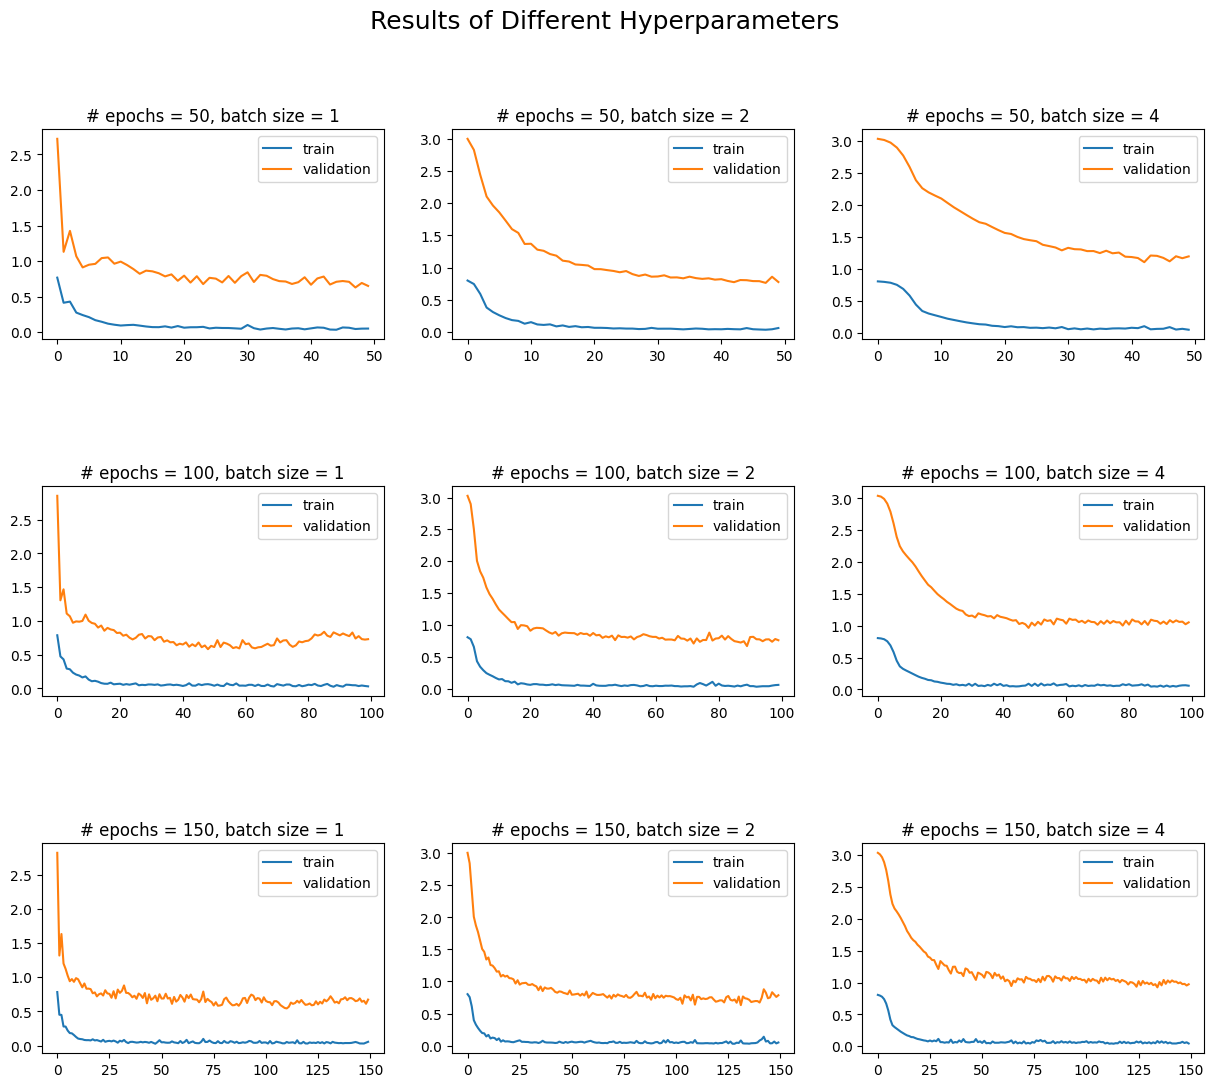

In [47]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.7)
plt.suptitle("Results of Different Hyperparameters", fontsize=18)
i = 0
models = []
np.random.seed(1)
for epoch in [50, 100, 150]:
    for batch_size in [1, 2, 4]:
        # design network
        model = Sequential()
        model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(2, kernel_initializer='normal', activation='linear'))
        model.add(Dense(1, kernel_initializer='normal', activation='linear'))
        model.compile(loss='mae', optimizer='adam')
        # fit network
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0, shuffle=False)
        models.append((model, history))
        # plotting the history of loss
        ax = plt.subplot(3, 3, i + 1)
        i += 1
        ax.plot(history.history['loss'], label='train')
        ax.plot(history.history['val_loss'], label='validation')
        ax.set_title(f"# epochs = {epoch}, batch size = {batch_size}")
        ax.legend()

The LSTM model performs pretty much the same with different # of epochs and batch sizes. We will choose the one with **# of epochs = 100** and **batch size = 1** in our case.

Epoch 1/100
84/84 - 8s - loss: 0.8095 - val_loss: 3.0324 - 8s/epoch - 94ms/step
Epoch 2/100
84/84 - 0s - loss: 0.7667 - val_loss: 2.7387 - 483ms/epoch - 6ms/step
Epoch 3/100
84/84 - 1s - loss: 0.5275 - val_loss: 1.9131 - 705ms/epoch - 8ms/step
Epoch 4/100
84/84 - 1s - loss: 0.4596 - val_loss: 1.8704 - 727ms/epoch - 9ms/step
Epoch 5/100
84/84 - 0s - loss: 0.3419 - val_loss: 1.6826 - 484ms/epoch - 6ms/step
Epoch 6/100
84/84 - 1s - loss: 0.2803 - val_loss: 1.5209 - 503ms/epoch - 6ms/step
Epoch 7/100
84/84 - 0s - loss: 0.2524 - val_loss: 1.4515 - 419ms/epoch - 5ms/step
Epoch 8/100
84/84 - 0s - loss: 0.2335 - val_loss: 1.4698 - 386ms/epoch - 5ms/step
Epoch 9/100
84/84 - 0s - loss: 0.1623 - val_loss: 1.3435 - 410ms/epoch - 5ms/step
Epoch 10/100
84/84 - 0s - loss: 0.1383 - val_loss: 1.2472 - 424ms/epoch - 5ms/step
Epoch 11/100
84/84 - 1s - loss: 0.1457 - val_loss: 1.2387 - 533ms/epoch - 6ms/step
Epoch 12/100
84/84 - 0s - loss: 0.1191 - val_loss: 1.1615 - 420ms/epoch - 5ms/step
Epoch 13/100
84

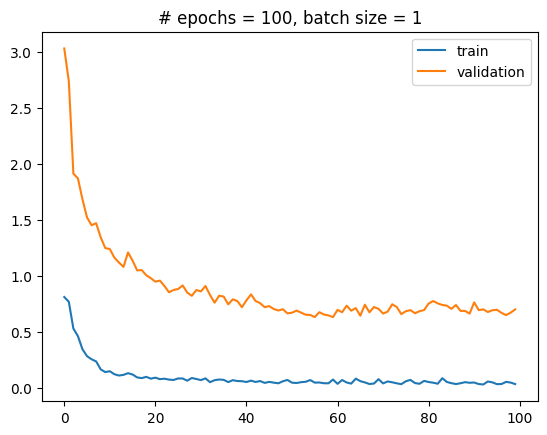

In [48]:
np.random.seed(1)
epoch = 100
batch_size = 1
# design network
model = Sequential()
model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)
# plotting the history of loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title(f"# epochs = {epoch}, batch size = {batch_size}")
plt.legend()

##### B5. Evaluate the performance of model B. Describe which measures you use and discuss the results of the evaluation.

Now that we have a trained model, we can predict the price of houses with 3 bedrooms in our test data to evaluate our model for each month.

In [49]:
# making predictions
yhat = model.predict(X_test)

# inverting scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat)
inv_yhat = inv_yhat[:,0]

dates = []
for y in range(2020, 2023):
    for m in range(1, 13):
        if y == 2022 and m == 8:
            break
        elif y == 2020 and m <= 3:
            continue
        dates.append(f"{m}-{y}")

df_results = pd.DataFrame(list(zip(dates, inv_yhat)), columns=["date", "prediction"])
df_results

1/1 [==============================] - 0s 486ms/step


,date,prediction
0,4-2020,573772.2500
1,5-2020,579832.2500
2,6-2020,580401.0000
3,7-2020,579245.1875
4,8-2020,584557.5625
5,9-2020,576157.6875
6,10-2020,576302.1250
7,11-2020,583612.3750
8,12-2020,595574.3125
9,1-2021,600054.5000


In [50]:
df_test = pd.read_csv('realestate_test.csv')
df_test = df_test[(df_test["type"]=="house") & (df_test["bedrooms"]==3)]
df_test["date"] = pd.to_datetime(df_test["date"])
df_test["year"] = df_test["date"].dt.year
df_test["month"] = df_test["date"].dt.month
df_test.drop(columns=["date", "type", "bedrooms"], inplace=True)
dates =[]
for idx, row in df_test.iterrows():
    dates.append(f"{row['month']}-{row['year']}")
df_test["date"] = dates
df_test.drop(columns=["year", "month"], inplace=True)
# we are excluding 07-2022 because we have shifted the date column by 1 while training
df_test = df_test[~df_test["date"].isin(["1-2020", "2-2020", "3-2020"]) ]
df_test

,price,date
812,712000,4-2020
815,885000,4-2020
822,742000,4-2020
824,465000,4-2020
825,487000,4-2020
...,...,...
7505,628000,7-2022
7506,731000,7-2022
7509,1130000,7-2022
7510,470000,7-2022


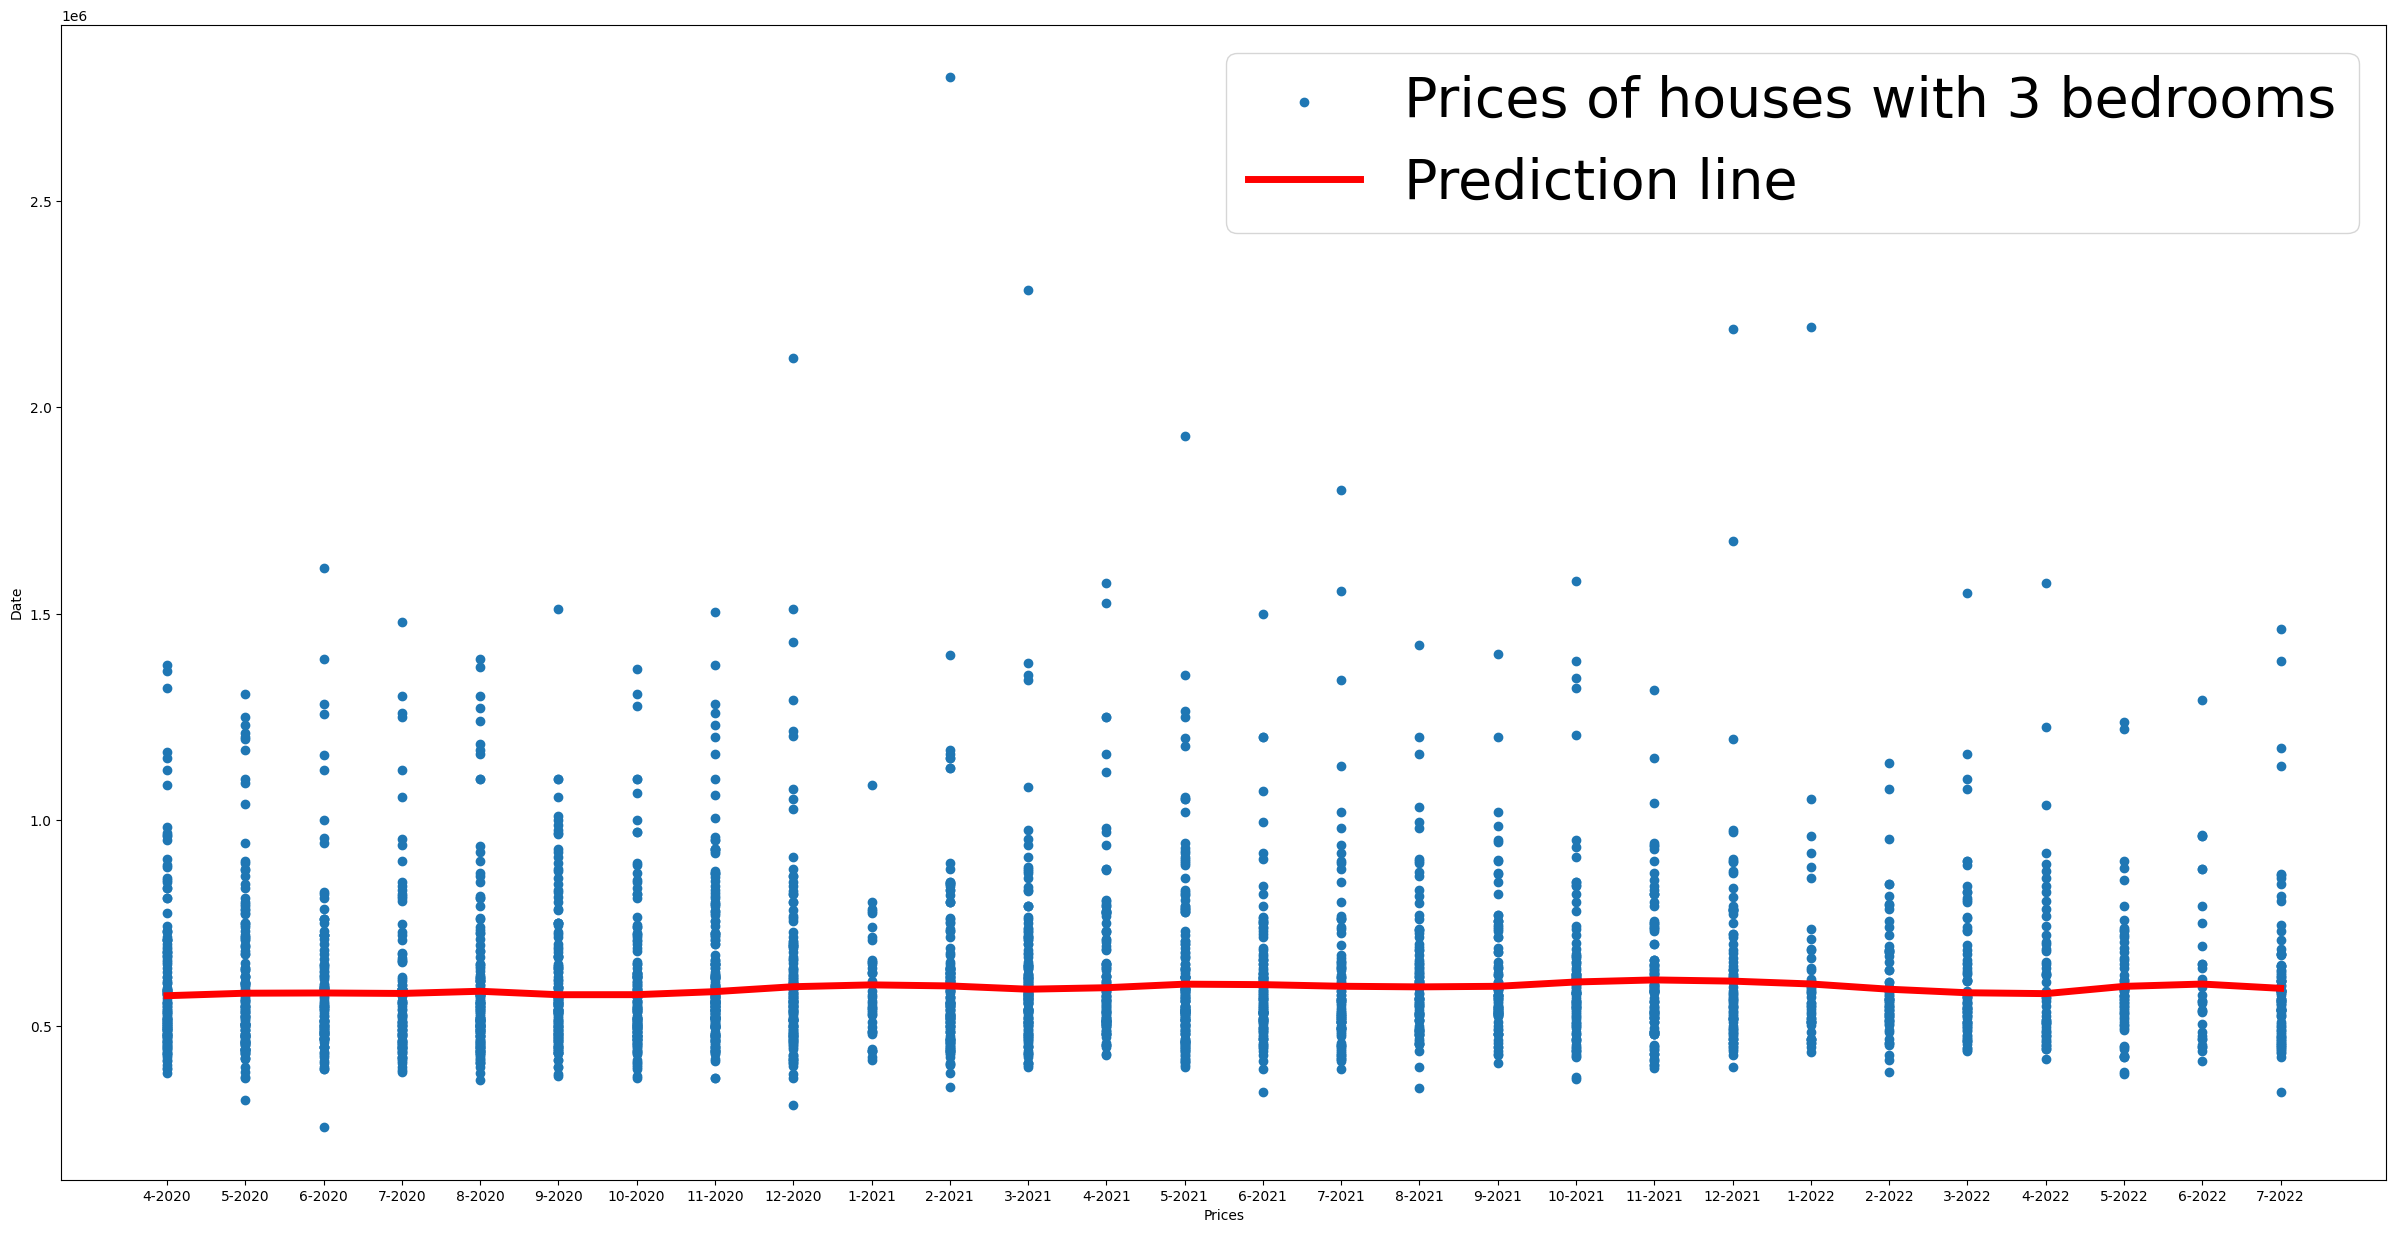

In [51]:
plt.figure(figsize=(30,15))
plt.scatter(df_test["date"], df_test["price"], label="Prices of houses with 3 bedrooms")
plt.plot(df_results["date"], df_results["prediction"], color="r", label="Prediction line", linewidth=5)
plt.xlabel("Prices")
plt.ylabel("Date")
plt.legend(prop={'size': 40})
plt.show()

In [52]:
absolute_errors = []
for idx, row in df_test.iterrows():
    pred = df_results[df_results["date"] == row["date"]]["prediction"].values[0]
    true = row["price"]
    absolute_errors.append(np.abs(true-pred))
print(f"Mean Absolute Error = {np.round(np.mean(absolute_errors), 0)}")

Mean Absolute Error = 129014.0


The mean absolute error of our model is  around 130k. Considering the price diversity of the houses with 3 bedrooms and the above graph, however; we can conclude that our model performed considerably well.

### Comparison

##### C1. Create a plot contrasting the predictions of model A, model B, and the ground truth values from the test set.

      date  prediction_model_A  prediction_model_B
0   1-2020         487041.7250         573772.2500
1   1-2020         523040.0000         579832.2500
2   1-2020         552787.5000         580401.0000
3   1-2020         557887.5000         579245.1875
4   1-2020         564050.0000         584557.5625
5   1-2020         566150.0000         576157.6875
6   1-2020         558962.5000         576302.1250
7   1-2020         551143.7500         583612.3750
8   1-2020         566912.5625         595574.3125
9   1-2020         565675.0000         600054.5000
10  1-2020         571762.5625         597481.5625
11  1-2020         581562.5625         589499.5000
12  1-2020         568400.0000         593142.0625
13  1-2020         571500.0000         601743.1250
14  1-2020         575162.5000         600617.1250
15  1-2020         581559.4375         596686.4375
16  1-2020         576287.5000         595170.3750
17  1-2020         575275.0000         596561.6875
18  1-2020         574550.0000 

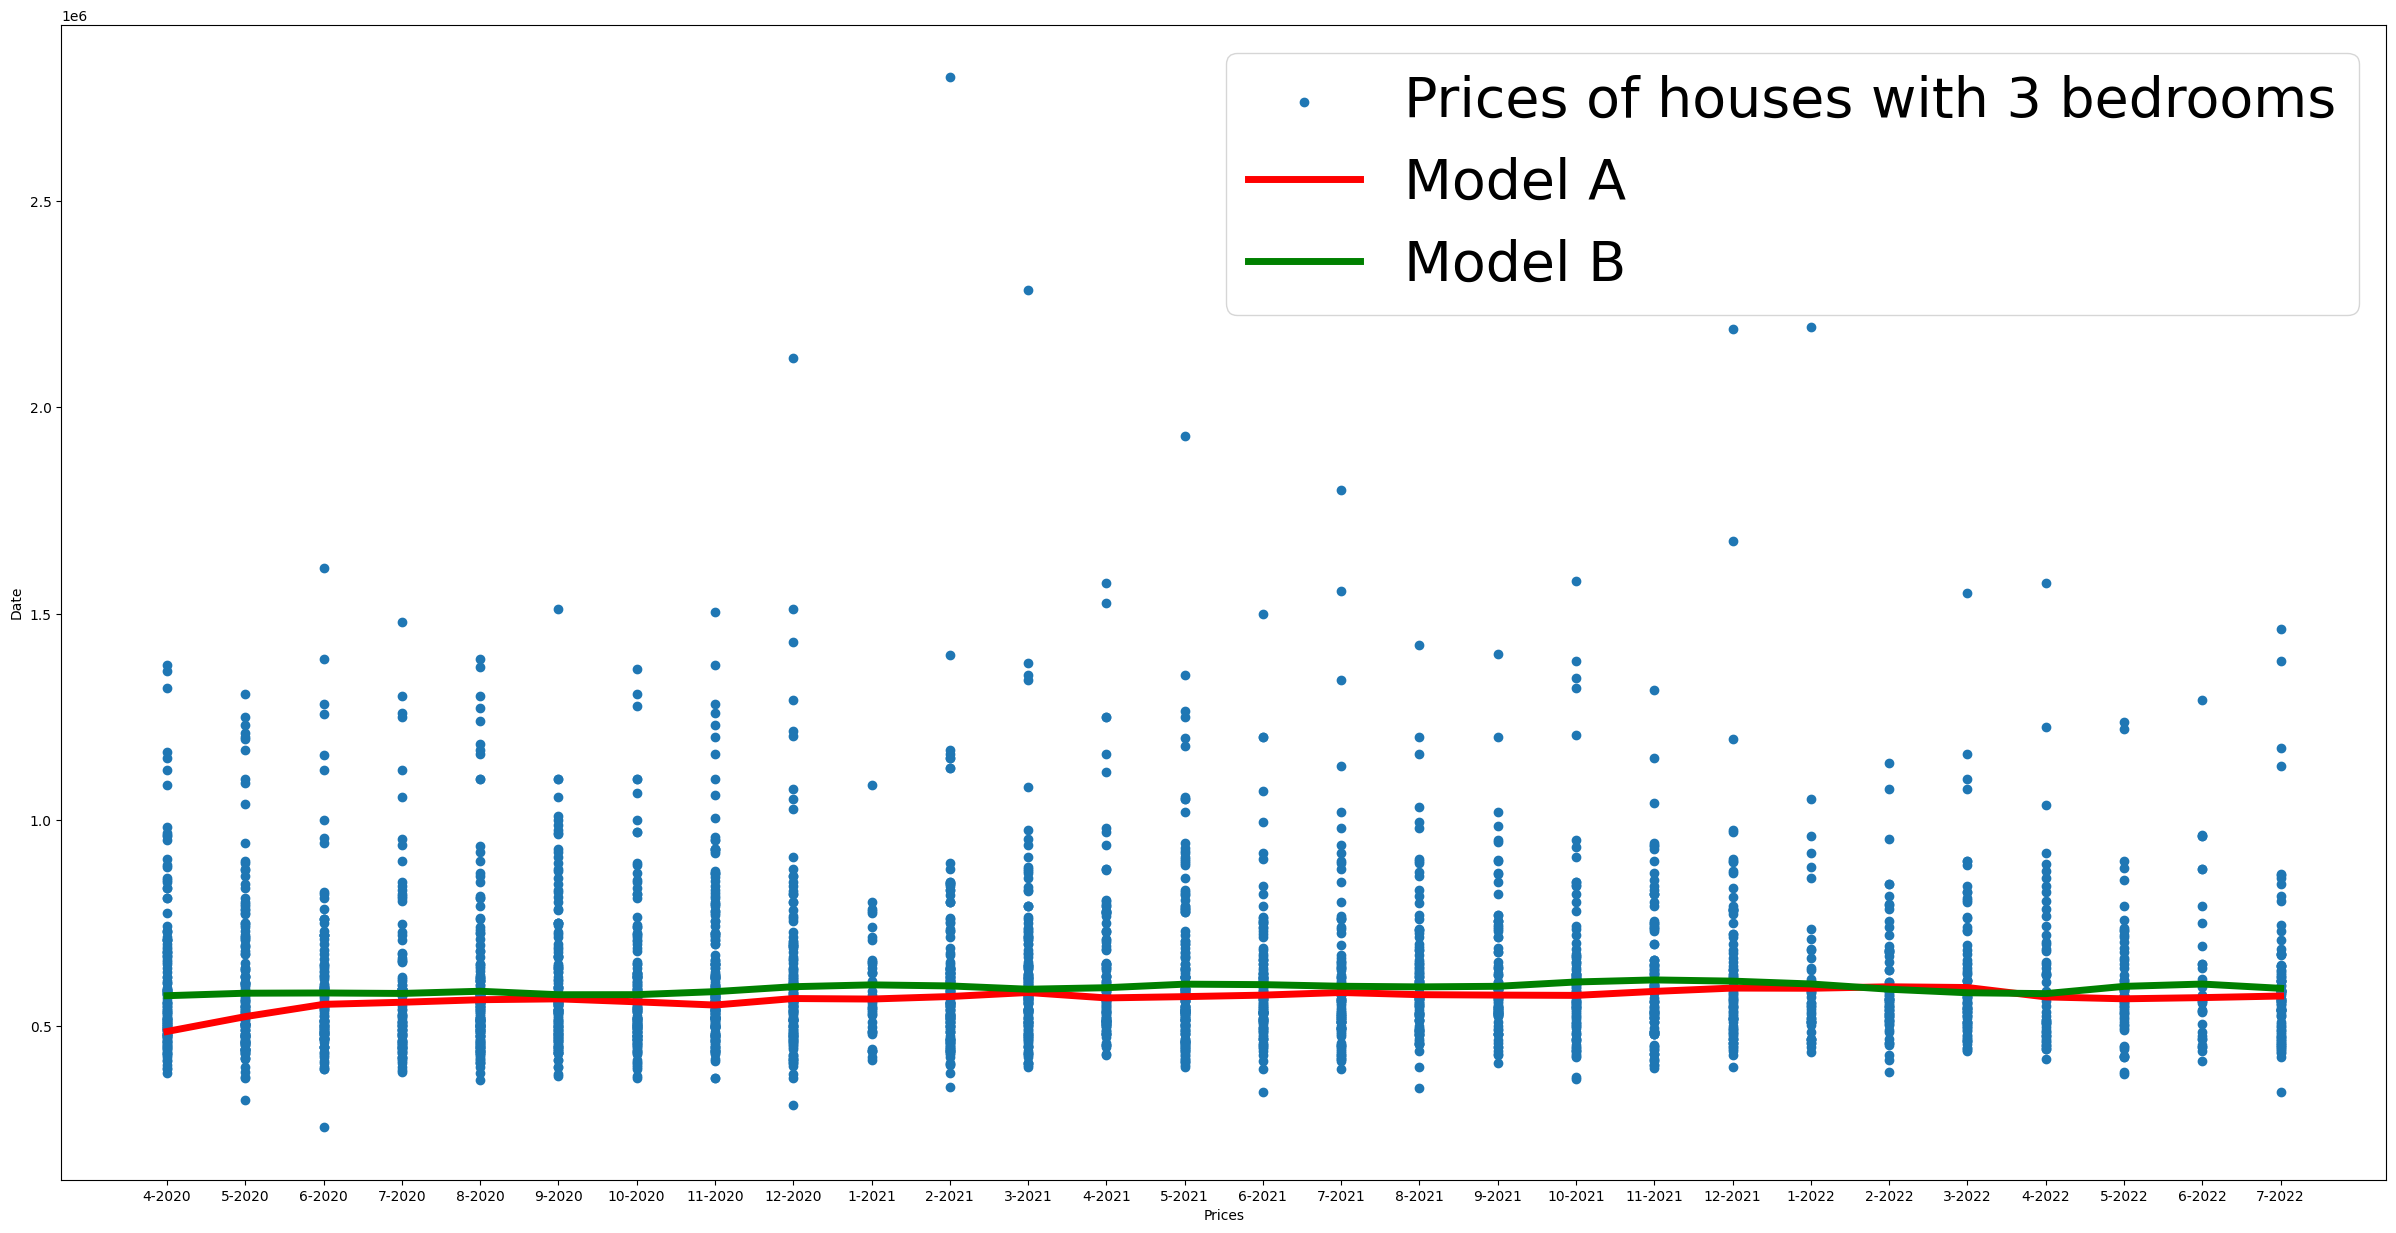

In [53]:
df_both = pd.DataFrame(list(zip(dates, preds, inv_yhat)), columns=["date", "prediction_model_A", "prediction_model_B"])
print(df_both)

predictions_A = df_both["prediction_model_A"]
predictions_B = df_both["prediction_model_B"]

plt.figure(figsize=(30,15))
plt.scatter(df_test["date"], df_test["price"], label="Prices of houses with 3 bedrooms")
plt.plot(df_results["date"], predictions_A, color="r", label="Model A", linewidth=5)
plt.plot(df_results["date"], predictions_B, color="g", label="Model B", linewidth=5)

plt.xlabel("Prices")
plt.ylabel("Date")
plt.legend(prop={'size': 40})
plt.show()

##### C2. Based on the results, which model would you recommend to the real estate company? Motivate your answer.

We would recommend the random forest model to the real estate company as the random forest model has a lower MAE than the RNN model, This is because the random forest model has shown to have better predictive accuracy on the test set.

However the performance of a model should be evaluated using multiple metrics  The real estate company may also want to consider other factors such as the interpretability of the model, the computational resources required to train and run the model and the ease of implementation in their existing infrastructure. as model A is taking longer as compare to model B.

Overall, as the complexity of the problem increase, we will expect LSTM based RNN model to be a better choice since RNN can easy to adapt to complexity by increasing the number dense layers.




